<a href="https://colab.research.google.com/github/Gold-gish/goldfish/blob/master/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_82 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_100 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_101 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

ValueError: ignored

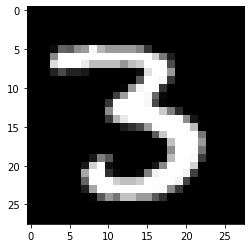

In [24]:
%tensorflow_version 2.x
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


class DCGAN():
  def __init__(self):
    (self.realimages,self.realimagesLabels),(_,_) = tf.keras.datasets.mnist.load_data()
    plt.imshow(self.realimages[12], 'gray')
    self.realimages = np.expand_dims(self.realimages,axis=3)

    self.realimages = (self.realimages-127.5)/127.5

    self.discriminator = self.discriminatorBuilder()
    self.discriminator.compile(loss='binary_crossentropy' , optimizer=tf.keras.optimizers.Adam(0.0002,0.5))

    self.generator = self.generatorBuilder()

    genInp   = tf.keras.layers.Input(shape=(100,))
    genLable = tf.keras.layers.Input(shape=(1,))
    genOut = self.generator((genInp, genLable))
    
    self.discriminator.trainable = False
    
    discOut = self.discriminator([genOut, genLable])

    self.generatorTrainerGan = tf.keras.models.Model([genInp, genLable], discOut)
    self.generatorTrainerGan.compile(loss='binary_crossentropy' , optimizer=tf.keras.optimizers.Adam(0.0002,0.5)) #note "optimizer!=)) optimizers"


  def generatorBuilder(self):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256, input_shape=(100,  )))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Dense(28*28, activation='tanh'))
    model.add(tf.keras.layers.Reshape((28,28)))
    model.summary()
    noise = tf.keras.layers.Input((100,))
    label = tf.keras.layers.Input((1,), dtype='int32')

    x = tf.keras.layers.Embedding(10, 100, input_length=1)(label)
    label_embedding = tf.keras.layers.Flatten()(x)
    model_input = tf.keras.layers.multiply([noise, label_embedding])
    img = model(model_input)

    return model




  def discriminatorBuilder(self):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28,28,1)))
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    model.summary()
    image = tf.keras.layers.Input((28,28))
    label = tf.keras.layers.Input((1, ), dtype='int32')
    label_embedding = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(10, 28*28)(label))
    flat_img = tf.keras.layers.Flatten()(image)
    model_input = tf.keras.layers.multiply([flat_img, label_embedding])


    output = model(model_input)
    return model



  def train(self,epochs,batchsize):
    realDiscOut = np.ones((batchsize,1))
    fakeDiscOut = np.zeros((batchsize,1))


    for epoch in range(epochs):
      randIndx = np.random.randint(0, self.realimages.shape[0], batchsize)
      randRealimages, labels = self.realimages[randIndx], self.realimagesLabels[randIndx]


      noise = np.random.normal(0, 1, (batchsize, 100))
      generatorOut = self.generator.predict([noise, labels])

      discriminatorLossReal = self.discriminator.train_on_batch([randRealimages, labels], realDiscOut)
      discriminatorLossFake = self.discriminator.train_on_batch([generatorOut, labels]  , fakeDiscOut)
      discriminatorLoss = 0.5* np.add(discriminatorLossFake, discriminatorLossReal)


      
      sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)


      generatorLoss = self.generatorTrainerGan.train_on_batch([noise, sampled_labels], realDiscOut)
      if (epoch % 50 == 0):
        plt.figure()
        noise = np.random.normal(0, 1, (1, 100))
        print(sampled_labels)
        plt.imshow(tf.reshape(self.generator.predict(noise), shape=(28, 28)), cmap='gray')


if __name__ == "__main__":
  dcganclass = DCGAN()
  dcganclass.train(3000,128)



